# 主力籌碼影響價格分析

本篇主要分析三大主力:

1. 外資
2. 投信
3. 自營商

三個主力分別對於市場價格有甚麼影響

### 匯入股票價格

In [3]:
import yfinance as yf
import matplotlib.pyplot as plt

[*********************100%%**********************]  1 of 1 completed


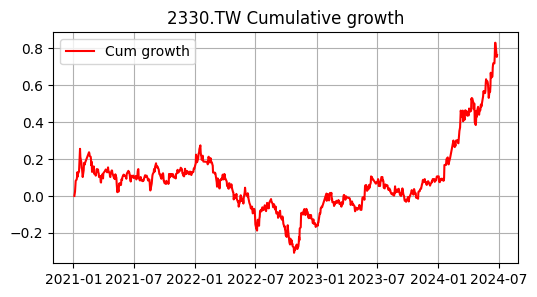

In [2]:
# 定義股票代碼和日期範圍
stock_code = "2330.TW"
start_date = "2021-01-01"
end_date = "2024-06-26"

# 獲取股價數據
df = yf.download(stock_code, start=start_date, end=end_date)

# 計算每日百分比成長率
pct_groth = df['Close'].pct_change().fillna(0)
cum_growth = (1 + pct_groth).cumprod() - 1

plt.figure(figsize=(6, 3))

plt.plot(df.index, cum_growth , color='red', label='Cum growth')

# 圖表標題和圖例
plt.title(f'{stock_code} Cumulative growth')

# 顯示圖表
plt.legend()
plt.grid(True)
plt.show()

In [4]:
import requests
url = "https://www.twse.com.tw/rwd/zh/fund/T86?date=20240626&selectType=ALL&response=json"
t = requests.get(url)
print(t)

<Response [200]>
